In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import seaborn as sns

# 1. Load & preprocess
df = pd.read_csv("Salary Prediction of Data Professions.csv")
y  = df['SALARY']
X  = df.drop('SALARY', axis=1)
X  = pd.get_dummies(X).dropna()
y  = y.loc[X.index]

In [5]:
df.head()

,FIRST NAME,LAST NAME,SEX,DOJ,CURRENT DATE,DESIGNATION,AGE,SALARY,UNIT,LEAVES USED,LEAVES REMAINING,RATINGS,PAST EXP
0,TOMASA,ARMEN,F,5-18-2014,01-07-2016,Analyst,21.0,44570,Finance,24.0,6.0,2.0,0
1,ANNIE,NaN,F,NaN,01-07-2016,Associate,NaN,89207,Web,NaN,13.0,NaN,7
2,OLIVE,ANCY,F,7-28-2014,01-07-2016,Analyst,21.0,40955,Finance,23.0,7.0,3.0,0
3,CHERRY,AQUILAR,F,04-03-2013,01-07-2016,Analyst,22.0,45550,IT,22.0,8.0,3.0,0
4,LEON,ABOULAHOUD,M,11-20-2014,01-07-2016,Analyst,NaN,43161,Operations,27.0,3.0,NaN,3


In [6]:
df.describe()

,AGE,SALARY,LEAVES USED,LEAVES REMAINING,RATINGS,PAST EXP
count,2636.000000,2639.000000,2636.000000,2637.000000,2637.000000,2639.000000
mean,24.756449,58136.678287,22.501517,7.503223,3.486159,1.566881
std,3.908228,36876.956944,4.604469,4.603193,1.114933,2.728416
min,21.000000,40001.000000,15.000000,0.000000,2.000000,0.000000
25%,22.000000,43418.000000,19.000000,4.000000,2.000000,0.000000
50%,24.000000,46781.000000,22.000000,8.000000,3.000000,1.000000
75%,25.000000,51401.500000,26.000000,11.000000,4.000000,2.000000
max,45.000000,388112.000000,30.000000,15.000000,5.000000,23.000000


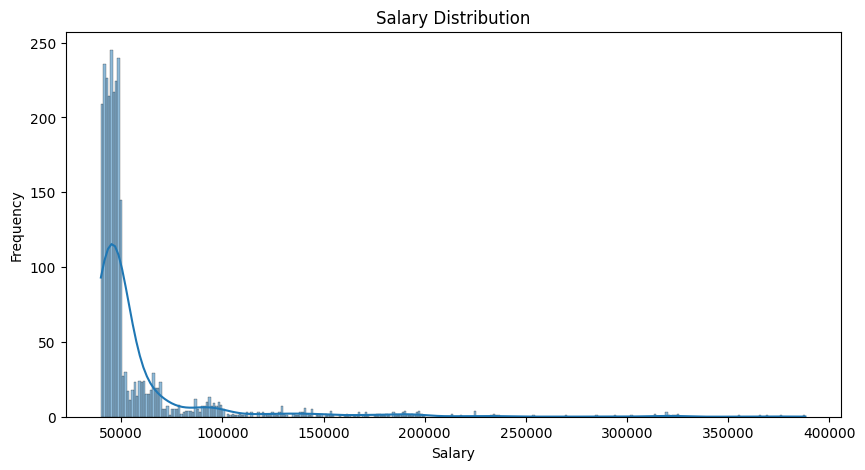

In [13]:
plt.figure(figsize=(10, 5))
sns.histplot(df['SALARY'], kde=True)
plt.title('Salary Distribution')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.show()
print()

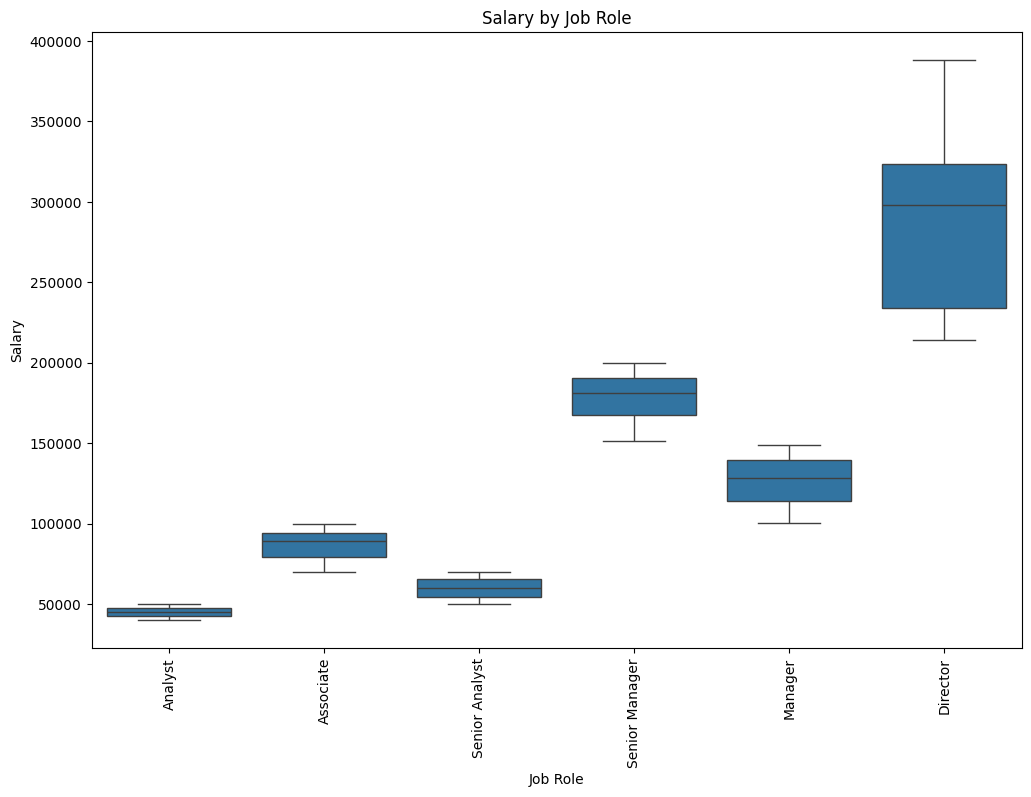

In [14]:
# Salary by Job Role
plt.figure(figsize=(12, 8))
sns.boxplot(x='DESIGNATION', y='SALARY', data=df)
plt.title('Salary by Job Role')
plt.xlabel('Job Role')
plt.ylabel('Salary')
plt.xticks(rotation=90)
plt.show()

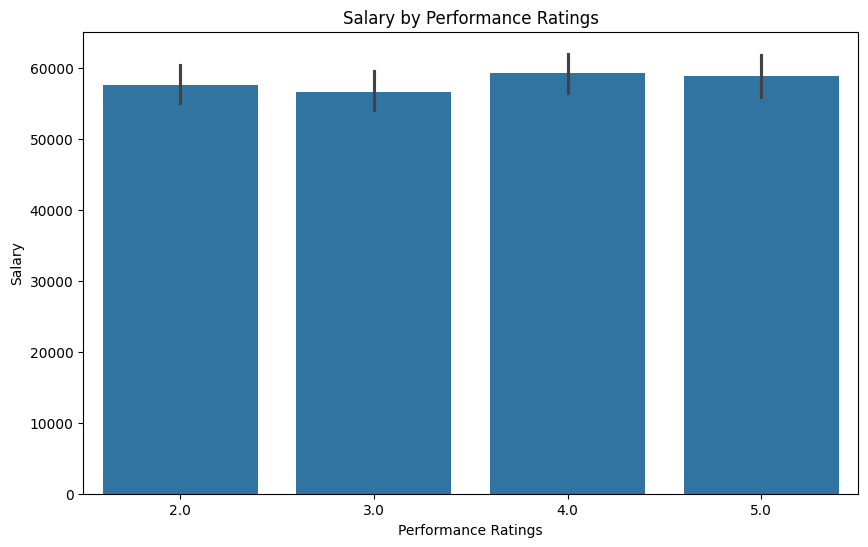

In [9]:
# Salary by Performance Ratings
plt.figure(figsize=(10, 6))
sns.barplot(x='RATINGS', y='SALARY', data=df)
plt.title('Salary by Performance Ratings')
plt.xlabel('Performance Ratings')
plt.ylabel('Salary')
plt.show()

In [4]:
# 2. Split 50% train / 25% test / 25% calib
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, train_size=0.5, random_state=42
)
X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp, train_size=0.5, random_state=42
)

In [5]:
# 3. Train baseline RF
rf = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [6]:
# 4. (Optional) Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth':    [None, 10, 20],
    'min_samples_split': [2, 5]
}
gs = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
gs.fit(X_train, y_train)
best_rf = gs.best_estimator_
print("Best RF params:", gs.best_params_)

# Evaluate before/after
for name, model in [("Baseline RF", rf), ("Optimized RF", best_rf)]:
    y_pred = model.predict(X_test)
    print(f"{name} test R²: {r2_score(y_test, y_pred):.4f}")

Best RF params: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Baseline RF test R²: 0.9214
Optimized RF test R²: 0.9226


In [7]:
# 5. Estimate σ via ensemble-std on both val and test
def estimate_sigma_ensemble(rf_model, X_):
    """
    Returns σ(x) ≈ std over the RF-ensemble predictions.
    """
    preds = np.stack([tree.predict(X_) for tree in rf_model.estimators_], axis=1)
    return preds.std(axis=1, ddof=1)

sigma_val  = estimate_sigma_ensemble(best_rf, X_val)
sigma_test = estimate_sigma_ensemble(best_rf, X_test)

/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWa

In [8]:
# 6. Nonconformity scores on calibration (val) set
y_val_pred   = best_rf.predict(X_val)
non_conf_scr = np.abs(y_val - y_val_pred) / sigma_val

In [9]:
# 7. Compute q-values
def compute_q_values(calib_scores: np.ndarray,
                     sigma: np.ndarray,
                     lambda_value: float) -> np.ndarray:
    n = calib_scores.shape[0]
    sorted_scores = np.sort(calib_scores)
    q_vals = np.empty(sigma.shape[0], dtype=float)
    for i, s in enumerate(sigma):
        threshold = lambda_value / s
        m_i = np.sum(sorted_scores <= threshold)
        if m_i == 0:
            q_vals[i] = 1.0
        else:
            q_vals[i] = max(0.0, 1.0 - m_i / (n + 1))
    return q_vals

lambda_value = 3500
alpha        = 0.2
q_vals       = compute_q_values(
    calib_scores = non_conf_scr.values,
    sigma        = sigma_test,
    lambda_value= lambda_value
)

In [11]:
# 8. Benjamini–Hochberg selection
def bh_selection(q_vals: np.ndarray, alpha: float) -> np.ndarray:
    m = q_vals.shape[0]
    order = np.argsort(q_vals)
    q_sorted = q_vals[order]
    thresholds = alpha * np.arange(1, m+1) / m
    below = q_sorted <= thresholds
    if not np.any(below):
        return np.array([], dtype=int)
    ell_star = np.max(np.where(below)[0]) + 1
    tau = alpha * ell_star / m
    return np.where(q_vals <= tau)[0]

S = bh_selection(q_vals, alpha)
print(f"Selected |S| = {len(S)} of {len(q_vals)} test points")

Selected |S| = 0 of 658 test points


In [12]:
# 9. Build adjusted conformal intervals
def adjusted_conformal_intervals(mu_pred: np.ndarray,
                                 sigma_pred: np.ndarray,
                                 calib_scores: np.ndarray,
                                 S: np.ndarray,
                                 alpha: float):
    m = mu_pred.shape[0]
    n = calib_scores.shape[0]
    alpha_prime = alpha * len(S) / m
    k = int(np.ceil((n + 1) * (1 - alpha_prime)))
    s_sorted = np.sort(calib_scores)
    # CORRECTED INDEXING: k-th order statistic is s_sorted[k-1]
    R_q_prime = s_sorted[k-1] if k <= len(s_sorted) else np.inf
    lower = mu_pred[S] - R_q_prime * sigma_pred[S]
    upper = mu_pred[S] + R_q_prime * sigma_pred[S]
    return lower, upper

mu_test_pred = best_rf.predict(X_test)
lower, upper = adjusted_conformal_intervals(
    mu_pred     = mu_test_pred,
    sigma_pred  = sigma_test,
    calib_scores= non_conf_scr.values,
    S           = S,
    alpha       = alpha
)

In [13]:
# 10. Verify interval lengths ≤ 2·λ
def verify_intervals_lengths(lower, upper, lambda_value):
    lengths = upper - lower
    if lengths.size == 0:
        print("No intervals to verify (empty S).")
        return
    max_len = lengths.max()
    print(f"Max interval length = {max_len:.2f}, 2·λ = {2*lambda_value:.2f}")
    if np.all(lengths <= 2*lambda_value):
        print("✅ All intervals respect the 2·λ bound.")
    else:
        bad = np.where(lengths > 2*lambda_value)[0]
        raise AssertionError(
            f"⚠️ {len(bad)} intervals exceed 2·λ; examples: {bad[:5]}"
        )

verify_intervals_lengths(lower, upper, lambda_value)

No intervals to verify (empty S).


In [ ]:
# 11. Empirical FCR on the selected points
def empirical_fcr(y_true, lower, upper) -> float:
    y_arr = np.array(y_true)
    mis = (y_arr < lower) | (y_arr > upper)
    return mis.mean()

y_sel = y_test.values[S]
fcr   = empirical_fcr(y_sel, lower, upper)
print(f"Empirical FCR = {fcr:.3f} (target ≤ {alpha})")

In [14]:
# InfoSCOP
# 12. Split 50% calib1 / 50% calib2
X_calib1, X_calib2, y_calib1, y_calib2 = train_test_split(
    X_val, y_val, train_size=0.5, random_state=42
)

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# 1. Load & preprocess
df = pd.read_csv("Salary Prediction of Data Professions.csv")
y  = df['SALARY']
X  = df.drop('SALARY', axis=1)
X  = pd.get_dummies(X).dropna()
y  = y.loc[X.index]

# 2. Split 50% train / 25% test / 25% calib
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, train_size=0.5, random_state=42
)
X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp, train_size=0.5, random_state=42
)

# 3. Train baseline RF
rf = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# 4. (Optional) Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth':    [None, 10, 20],
    'min_samples_split': [2, 5]
}
gs = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
gs.fit(X_train, y_train)
best_rf = gs.best_estimator_
print("Best RF params:", gs.best_params_)

# Evaluate before/after
for name, model in [("Baseline RF", rf), ("Optimized RF", best_rf)]:
    y_pred = model.predict(X_test)
    print(f"{name} test R²: {r2_score(y_test, y_pred):.4f}")

# 5. Estimate σ via ensemble-std on both val and test
def estimate_sigma_ensemble(rf_model, X_):
    """
    Returns σ(x) ≈ std over the RF-ensemble predictions.
    """
    preds = np.stack([tree.predict(X_) for tree in rf_model.estimators_], axis=1)
    return preds.std(axis=1, ddof=1)

sigma_val  = estimate_sigma_ensemble(best_rf, X_val)
sigma_test = estimate_sigma_ensemble(best_rf, X_test)

# 6. Nonconformity scores on calibration (val) set
y_val_pred   = best_rf.predict(X_val)
non_conf_scr = np.abs(y_val - y_val_pred) / sigma_val

# 7. Compute q-values
def compute_q_values(calib_scores: np.ndarray,
                     sigma: np.ndarray,
                     lambda_value: float) -> np.ndarray:
    n = calib_scores.shape[0]
    sorted_scores = np.sort(calib_scores)
    q_vals = np.empty(sigma.shape[0], dtype=float)
    for i, s in enumerate(sigma):
        threshold = lambda_value / s
        m_i = np.sum(sorted_scores <= threshold)
        if m_i == 0:
            q_vals[i] = 1.0
        else:
            q_vals[i] = max(0.0, 1.0 - m_i / (n + 1))
    return q_vals

lambda_value = 3500
alpha        = 0.2
q_vals       = compute_q_values(
    calib_scores = non_conf_scr.values,
    sigma        = sigma_test,
    lambda_value= lambda_value
)

# 8. Benjamini–Hochberg selection
def bh_selection(q_vals: np.ndarray, alpha: float) -> np.ndarray:
    m = q_vals.shape[0]
    order = np.argsort(q_vals)
    q_sorted = q_vals[order]
    thresholds = alpha * np.arange(1, m+1) / m
    below = q_sorted <= thresholds
    if not np.any(below):
        return np.array([], dtype=int)
    ell_star = np.max(np.where(below)[0]) + 1
    tau = alpha * ell_star / m
    return np.where(q_vals <= tau)[0]

S = bh_selection(q_vals, alpha)
print(f"Selected |S| = {len(S)} of {len(q_vals)} test points")

# 9. Build adjusted conformal intervals
def adjusted_conformal_intervals(mu_pred: np.ndarray,
                                 sigma_pred: np.ndarray,
                                 calib_scores: np.ndarray,
                                 S: np.ndarray,
                                 alpha: float):
    m = mu_pred.shape[0]
    n = calib_scores.shape[0]
    alpha_prime = alpha * len(S) / m
    k = int(np.ceil((n + 1) * (1 - alpha_prime)))
    s_sorted = np.sort(calib_scores)
    # CORRECTED INDEXING: k-th order statistic is s_sorted[k-1]
    R_q_prime = s_sorted[k-1] if k <= len(s_sorted) else np.inf
    lower = mu_pred[S] - R_q_prime * sigma_pred[S]
    upper = mu_pred[S] + R_q_prime * sigma_pred[S]
    return lower, upper

mu_test_pred = best_rf.predict(X_test)
lower, upper = adjusted_conformal_intervals(
    mu_pred     = mu_test_pred,
    sigma_pred  = sigma_test,
    calib_scores= non_conf_scr.values,
    S           = S,
    alpha       = alpha
)

# 10. Verify interval lengths ≤ 2·λ
def verify_intervals_lengths(lower, upper, lambda_value):
    lengths = upper - lower
    if lengths.size == 0:
        print("No intervals to verify (empty S).")
        return
    max_len = lengths.max()
    print(f"Max interval length = {max_len:.2f}, 2·λ = {2*lambda_value:.2f}")
    if np.all(lengths <= 2*lambda_value):
        print("✅ All intervals respect the 2·λ bound.")
    else:
        bad = np.where(lengths > 2*lambda_value)[0]
        raise AssertionError(
            f"⚠️ {len(bad)} intervals exceed 2·λ; examples: {bad[:5]}"
        )

verify_intervals_lengths(lower, upper, lambda_value)

# 11. Empirical FCR on the selected points
def empirical_fcr(y_true, lower, upper) -> float:
    y_arr = np.array(y_true)
    mis = (y_arr < lower) | (y_arr > upper)
    return mis.mean()

y_sel = y_test.values[S]
fcr   = empirical_fcr(y_sel, lower, upper)
print(f"Empirical FCR = {fcr:.3f} (target ≤ {alpha})")


KeyboardInterrupt: 